
# Case Study 5: Bayesian Neural Network

Adapted from https://num.pyro.ai/en/stable/examples/bnn.html , we first see the NumPyro implementation and then SOGA.


In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
print(sys.path)

['/Users/rominadoz/micromamba/envs/simple_env/lib/python312.zip', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/lib-dynload', '', '/Users/rominadoz/micromamba/envs/simple_env/lib/python3.12/site-packages', '/Users/rominadoz/Desktop/Home/PhD/SOGA/DeGAS/src']


In [3]:
from sogaPreprocessor import *
from producecfg import *
from smoothcfg import *
from libSOGA import *
from time import time

from utils import get_data, mean_squared_error, mean_squared_error_bayes, neg_log_likelihood, neg_log_likelihood_one
import vi_model

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import pyro.optim
from pyro.infer import SVI, Trace_ELBO
from pyro.distributions import constraints
import pyro.distributions as dist

torch.set_default_dtype(torch.float32)

### Training the BNN with VI in Pyro

X.shape torch.Size([100, 1, 1]) Y.shape torch.Size([100, 1, 1])


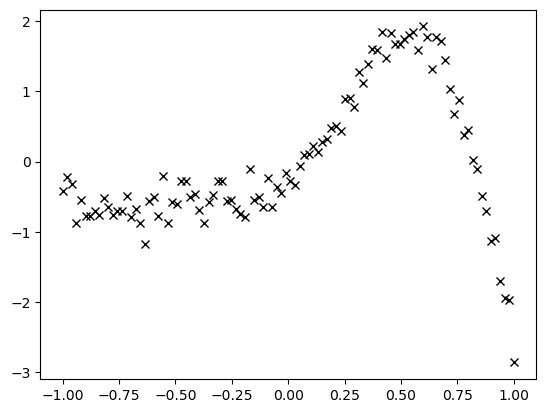

In [4]:
args = [100, 2, 4]
N, D_X, D_H = args
X, Y, X_test = get_data(N=N, D_X=D_X)
X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

print('X.shape', X.shape, 'Y.shape', Y.shape)
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")

In [5]:
# Example usage

start = time()
losses = vi_model.train_vi(vi_model.model, vi_model.guide, X, Y, D_H, num_steps = 20000)
end = time()
print("Training time:", end - start)

Step 0 - Loss: 6746.48876953125
Step 2000 - Loss: 4497.068834125996
Step 4000 - Loss: 1582.2875468730927
Step 6000 - Loss: 871.8499902486801
Step 8000 - Loss: 863.6329500675201
Step 10000 - Loss: 886.0989558696747
Step 12000 - Loss: 175.41834449768066
Step 14000 - Loss: 111.75732421875
Step 16000 - Loss: 129.91277313232422
Step 18000 - Loss: 112.2885115146637
Training complete!
Training time: 56.84933090209961


In [6]:
for name, value in pyro.get_param_store().items():
    print(f"{name}: {value.detach().numpy()}")

w1_loc: [[ 1.8180491 -2.6542861  3.2456646 -2.565018 ]]
w1_scale: [[0.01935011 0.01500836 0.00760057 0.011563  ]]
b1_loc: [-1.5524917 -0.0969602 -2.1649442  1.1514815]
b1_scale: [0.01901484 0.00860332 0.00622946 0.00610312]
w3_loc: [[-1.916054 ]
 [ 1.6573377]
 [-3.4423494]
 [-1.7949464]]
w3_scale: [[0.17382732]
 [0.00833557]
 [0.03976421]
 [0.00601515]]
b3_loc: [1.7192795]
b3_scale: [0.0091036]


In [7]:
Y_train = vi_model.predict_vi(X, pyro.param)

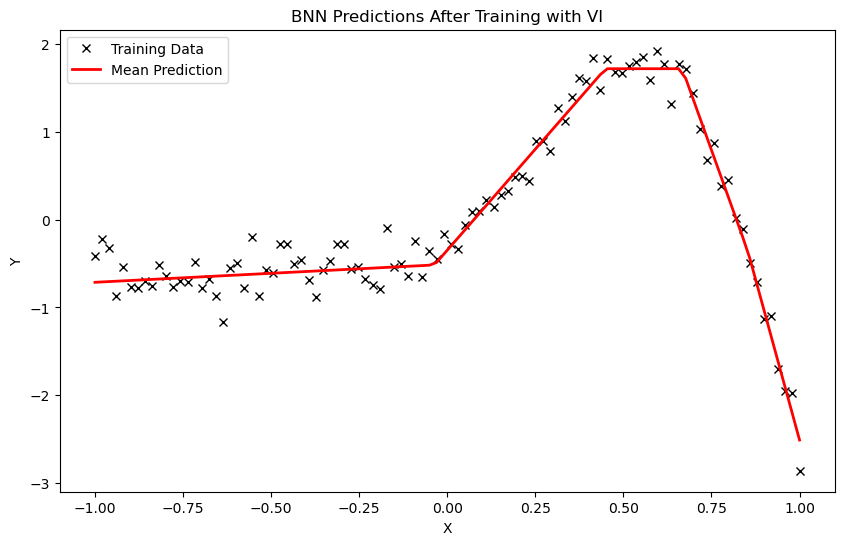

In [8]:


# Visualize the results of the BNN trained using Variational Inference
plt.figure(figsize=(10, 6))

# Plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx", label="Training Data")

# Predictive mean after training

# Plot mean prediction
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="Mean Prediction")

# Add labels, legend, and title
plt.xlabel("X")
plt.ylabel("Y")
plt.title("BNN Predictions After Training with VI")
plt.legend()

# Show the plot
plt.show()

### Sanity check on SOGA program

We use the parameters found by VI in SOGA to check that the BNN is correctly encoded

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_47954/1811175586.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss += neg_log_likelihood_one(torch.tensor(Y.squeeze(-1)[j], dtype=torch.float64 ), current_dist)


Loss SOGA: 7.37281250661346


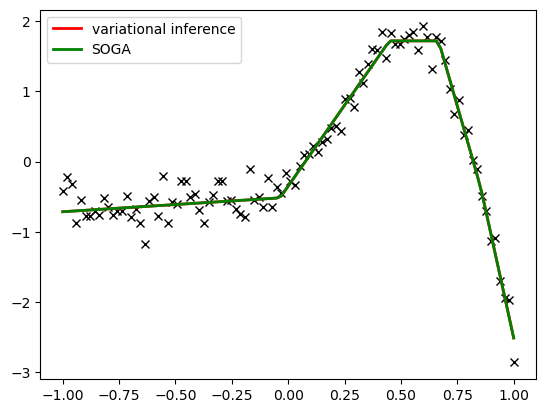

In [ ]:
torch.set_default_dtype(torch.float64)

# What happens if we use the parameters found by MCMC in SOGA?

w1_mean, w2_mean, w3_mean, w4_mean = pyro.param("w1_loc").detach().numpy()[0]
w5_mean, w6_mean, w7_mean, w8_mean = pyro.param('w3_loc').detach().numpy()[:, 0]
b1_mean, b2_mean, b3_mean, b4_mean = pyro.param("b1_loc").detach().numpy()
b5_mean = pyro.param("b3_loc").detach().numpy()[0]

w1_std, w2_std, w3_std, w4_std = pyro.param("w1_scale").detach().numpy()[0]
w5_std, w6_std, w7_std, w8_std = pyro.param('w3_scale').detach().numpy()[:, 0]
b1_std, b2_std, b3_std, b4_std = pyro.param("b1_scale").detach().numpy()
b5_std = pyro.param("b3_scale").detach().numpy()[0]

# This is the X vector used in the script
X_soga = torch.tensor(X.squeeze(-1).squeeze(-1).numpy(), dtype=torch.float64)

compiledFile=compile2SOGA('../../programs/SOGA/Optimization/CaseStudies/bnn3.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

vi_pars = {'muw1':w1_mean, 'muw2': w2_mean, 'muw3': w3_mean, 'muw4': w4_mean, 'muw5': w5_mean, 'muw6': w6_mean, 'muw7': w7_mean, 'muw8': w8_mean,  
            'mub1': b1_mean, 'mub2': b2_mean, 'mub3': b3_mean, 'mub4': b4_mean, 'mub5': b5_mean,
            'sigmaw1': w1_std, 'sigmaw2': w2_std, 'sigmaw3': w3_std, 'sigmaw4': w4_std, 'sigmaw5': w5_std, 'sigmaw6': w6_std, 'sigmaw7': w7_std, 'sigmaw8': w8_std,
            'sigmab1': b1_std, 'sigmab2': b2_std, 'sigmab3': b3_std, 'sigmab4': b4_std, 'sigmab5': b5_std,}

for key, value in vi_pars.items():
    vi_pars[key] = torch.tensor(value, requires_grad=True)

y_means = []
loss = 0.
for j in range(len(X.squeeze(-1).squeeze(-1))):
    xj = X.squeeze([-1,1])[j]
    vi_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, vi_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())
    loss += neg_log_likelihood_one(torch.tensor(Y.squeeze(-1)[j], dtype=torch.float64 ), current_dist)   

#output_dist = start_SOGA(cfg, vi_pars, pruning='ranking') #params_dict 


plt.plot(X.numpy().flatten(), Y.numpy().flatten(), "kx")
#plt.plot(X.numpy().flatten(), Y_samples_mean, "blue", ls="solid", lw=2.0, label='sampling')
plt.plot(X.squeeze(-1).numpy(), Y_train.squeeze(-1).detach().numpy(), "r", lw=2.0, label="variational inference")
plt.plot(X_soga.numpy().flatten(), y_means, "green", ls="solid", lw=2.0, label='SOGA')

plt.legend()

print("Loss SOGA:", loss.item())


### Optimization in SOGA

We use a different script in which the std of the weights are fixed (if not the loss is better for higher stds).
Moreover we add noise to the output to avoid infinite loss

In [ ]:
torch.set_default_dtype(torch.float64)

bnn_one_pars = {'muw1': -1.0, 'muw2': 1.0, 'muw3': -1.0, 'muw4': -1.0, 'mub1': 1.0, 'mub2': -1.0, 'mub3': 1.0}

bnn_one_pars = {'muw1':1., 'muw2': -1., 'muw3': 1., 'muw4': -1., 'muw5': -1., 'muw6': 1., 'muw7': -1., 'muw8': -1.,  
            'mub1': -1., 'mub2': -1., 'mub3': -1., 'mub4': 1., 'mub5': 1.,
            'sigmaw1': 0.1, 'sigmaw2': 0.1, 'sigmaw3': 0.1, 'sigmaw4': 0.1, 'sigmaw5': 0.1, 'sigmaw6': 0.1, 'sigmaw7': 0.1, 'sigmaw8': 0.1,
            'sigmab1': 0.1, 'sigmab2': 0.1, 'sigmab3': 0.1, 'sigmab4': 0.1, 'sigmab5': 0.1,}


for key, value in bnn_one_pars.items():
    bnn_one_pars[key] = torch.tensor(value, requires_grad=True)    


compiledFile=compile2SOGA('../../programs/SOGA/Optimization/CaseStudies/bnn3.soga')
cfg = produce_cfg(compiledFile)
smooth_cfg(cfg)

lr = 0.001
steps = 1000

#optimize(bnn_one_pars, neg_log_likelihood, Y.squeeze(-1).t(), cfg, steps=100, lr = 0.0001)

optimizer = torch.optim.Adam([bnn_one_pars[key] for key in bnn_one_pars.keys()], lr)

total_start = time()

batch_size = 20

for i in range(steps):

    optimizer.zero_grad()  # Reset gradients
    loss = 0
    for j in range(batch_size):
        sampled_index = np.random.randint(0, len(Y.squeeze([-1,1])))
        yj = Y.squeeze([1])[sampled_index].to(torch.float64)
        xj = X.squeeze([-1,1])[sampled_index]
        bnn_one_pars['x'] = xj.requires_grad_(False)

        current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')

        loss += neg_log_likelihood_one(yj, current_dist)

    # Backpropagate
    loss.backward(retain_graph=True)
    
    optimizer.step()

    # Print progress
    if i % int(steps/10) == 0:
        out = ''
        
        out = out + f" loss: {loss.item()}"

        for key in bnn_one_pars.keys():
            out = out + key + ': ' + str(bnn_one_pars[key].item()) + ' '
            
        print(out)

    total_end = time()

print('Optimization performed in ', round(total_end-total_start, 3))

 loss: 295.2231471813103muw1: 1.0009999999999495 muw2: -1.000999999992184 muw3: 1.0009999999999495 muw4: -0.9990000000000414 muw5: -1.0009999999998662 muw6: 1.000999999993702 muw7: -1.0009999999998662 muw8: -1.0009999999999328 mub1: -0.9990000000000476 mub2: -0.9990000000071023 mub3: -0.9990000000000476 mub4: 1.00099999999996 mub5: 0.9990000000000903 sigmaw1: 0.10099999999997579 sigmaw2: 0.10099999999060592 sigmaw3: 0.10099999999997579 sigmaw4: 0.10099999999998377 sigmaw5: 0.10099999999933244 sigmaw6: 0.10099999993201535 sigmaw7: 0.10099999999933244 sigmaw8: 0.10099999999993367 sigmab1: 0.1009999999999784 sigmab2: 0.1009999999923667 sigmab3: 0.1009999999999784 sigmab4: 0.10099999999998938 sigmab5: 0.10099999999999325 x: -0.21212121844291687 


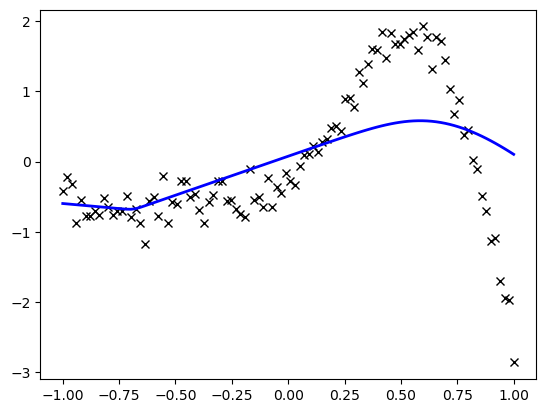

In [27]:
y_means = []
for j in range(len(Y.squeeze([-1,1]))):
    yj = Y.squeeze([1])[j].to(torch.float64)
    xj = X.squeeze([-1,1])[j]
    bnn_one_pars['x'] = xj.requires_grad_(False)

    current_dist = start_SOGA(cfg, bnn_one_pars, pruning='ranking')
    y_means.append(current_dist.gm.mean()[current_dist.var_list.index('y')].detach().numpy())

# plot training data
plt.plot(X.squeeze(-1).numpy(), Y.squeeze(-1).numpy(), "kx")
# plot 90% confidence level of predictions
#plt.fill_between(X.numpy().flatten(), percentiles[0, :], percentiles[1, :], color="lightblue")
# plot mean prediction
plt.plot(X.numpy().flatten(), y_means, "blue", ls="solid", lw=2.0)
#ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI")
plt.show()